# Libraries and GPU Checks

In [1]:
######################################################Initial Packages########################################################
#Basic Operating System Stuff
import os, gc, random

#Basic dataframe, array, and math stuff
import pandas as pd #data frame
import math #math functions
import numpy as np    #numerical package

#Scikit learn
import sklearn as sk  #scikit learn
from sklearn import metrics
from sklearn.model_selection import train_test_split as tts #train test split
from sklearn.metrics import confusion_matrix, roc_curve, classification_report #for 2-class model
from sklearn.preprocessing import MinMaxScaler as MMS

#Tensorflow
import tensorflow as tf 
from tensorflow.python.client import device_lib #GPU Check
import tensorflow.keras #keras
from tensorflow.keras import layers 
from tensorflow.keras import Sequential,Input,Model 
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input, Add, Activation, ZeroPadding2D,GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization,Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, LeakyReLU  
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint #use for early stopping and reduction on level-out
from tensorflow.keras.initializers import glorot_uniform, he_uniform #to initialize random weights for filters
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.preprocessing import image as image_utils
from tensorflow.keras.applications.imagenet_utils import preprocess_input, decode_predictions, preprocess_input
from tensorflow.keras.models import Model, load_model  #Can't do much without a model
from tensorflow.keras import utils
from tensorflow.keras.utils import get_file, plot_model, to_categorical, model_to_dot
from tensorflow.keras.metrics import AUC
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import ResNet50V2, MobileNetV2, VGG16 
import tensorflow.keras.backend as K #let's write our own metrics and loss functions

#Graphing
import cv2
import matplotlib.pyplot as plt

print(device_lib.list_local_devices()) #Let's see if Python recognizes my GPU, shall we?
################################################conda ##############################################################################

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17827197302993375537
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 6609022213316879629
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6918604064
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1740932619098446768
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2080 Super, pci bus id: 0000:01:00.0, compute capability: 7.5"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 13703555689731195153
physical_device_desc: "device: XLA_GPU device"
]


# GPU and Memory Management

In [2]:
mirrored_strategy = tf.distribute.MirroredStrategy()
#mirrored_strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1", ":/gpu:2", ":gpu:3"])
def reset_keras():
    tensorflow.keras.backend.clear_session
reset_keras()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


# Read Function

In [3]:
random.seed(1234) #set the random seed
images,labels=[], []  #storage for images and labels from the tensorflow files
size=96  #image size

features = {
    'label': tf.io.FixedLenFeature([], tf.int64),
    'label_normal': tf.io.FixedLenFeature([], tf.int64),
    'image': tf.io.FixedLenFeature([], tf.string)
    }

def readFile(files):
    mydata = tf.data.TFRecordDataset(files,num_parallel_reads=4).shuffle(buffer_size=10000).cache()
    mydata = mydata.map(lambda x: tf.io.parse_example(x, features), num_parallel_calls=4)
    for image_features in mydata:
        image = tf.io.decode_raw(image_features['image'], tf.uint8)
        image = tf.reshape(image, [299, 299])        
        image=image.numpy()
        image=cv2.resize(image,(size,size))
        image=cv2.merge([image,image,image])        
        images.append(image)
        #labels.append(image_features['label_normal'].numpy()) #label_normal for 2-class classification
        labels.append(image_features['label'].numpy()) #for multi-class classification

# Read Training

In [4]:
reset_keras()
files=['D:/breast/training10_0/training10_0.tfrecords',
          'D:/breast/training10_1/training10_1.tfrecords',
          'D:/breast/training10_2/training10_2.tfrecords',
          'D:/breast/training10_3/training10_3.tfrecords',
          'D:/breast/training10_4/training10_4.tfrecords'
          ]
for file in files:
    readFile(file)

# Verify Which Codes are 1 and Which are Zero

In [5]:
np.bincount(labels)/len(labels)
#1s and above are positive

array([0.86957144, 0.03763085, 0.03419522, 0.02617876, 0.03242373])

# Group

In [6]:
x_train=np.array(images)
x_train=x_train/255
y_train=np.array(labels)
y_train=np.where(y_train==0, 0, y_train)
y_train=np.where(y_train!=0, 1, y_train)
np.bincount(y_train)/len(y_train)

array([0.86957144, 0.13042856])

# Read Test

In [7]:
reset_keras()

#Per instructions, we need to combine both the val and test sets due to a parsing error during creation
x_test=np.concatenate((np.load("d:/breast/cv10_data/cv10_data.npy"),np.load("d:/breast/test10_data/test10_data.npy")))        
y_test=np.concatenate((np.load("d:/breast/cv10_labels.npy"),np.load("d:/breast/test10_labels.npy")))
                      
y_test=np.where(y_test==0, 0, y_test)
y_test=np.where(y_test!=0, 1, y_test)

sizeit=[]  #array for image resizing

#image resizing
for i in np.arange(x_test.shape[0]):
    mytemp=cv2.resize(x_test[i,:,:,:],(size,size))
    mytemp2=cv2.cvtColor(mytemp,cv2.COLOR_GRAY2RGB)
    sizeit.append(mytemp2)
    
x_test=np.asarray(sizeit)
x_test=x_test/255

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)


(55885, 96, 96, 3) (55885,) (15364, 96, 96, 3) (15364,)


# Plot Some Images

10

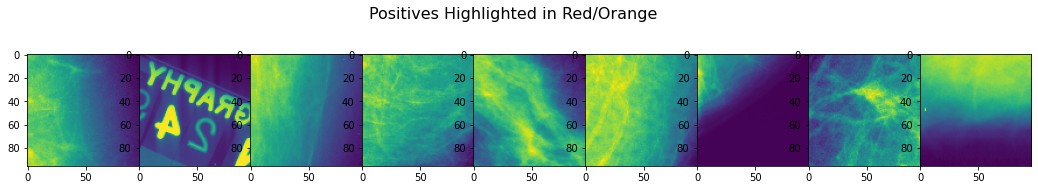

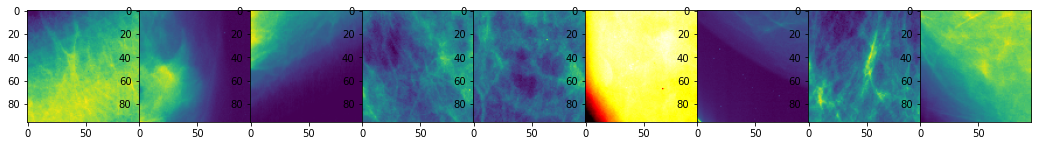

In [8]:
reset_keras() #clear memory
fig, ax = plt.subplots(1,9, figsize=[18, 3])  #set first figure
fig2, ax2 = plt.subplots(1,9, figsize=[18, 3]) #set second figure
fig.suptitle('Positives Highlighted in Red/Orange', fontsize=16)
for i in range(9):
    ax[i].imshow(x_train[i, :,:,0]) if y_train[i]==0 else ax[i].imshow(x_train[i, :,:,0],'hot') 
    fig.subplots_adjust(wspace=0, hspace=0)
for i in range(9):
    ax2[i].imshow(x_train[i+9, :,:,0]) if y_train[i+9]==0 else ax2[i].imshow(x_train[i+9,:,:,0],'hot') 
    fig2.subplots_adjust(wspace=0, hspace=0)

del(images)
del(labels)    
gc.collect()

# Autoencoder

from tensorflow.keras.optimizers import Adam

#build a sequential autoencoder as a neural network

autoencoder = Sequential()
autoencoder.add(Dense(512,  activation='elu',input_shape=(55885,)))
autoencoder.add(Dense(128,  activation='elu'))
autoencoder.add(Dense(64,  activation='elu'))
autoencoder.add(Dense(10,    activation='linear', name="bottleneck"))
autoencoder.add(Dense(64,  activation='elu'))
autoencoder.add(Dense(128,  activation='elu'))
autoencoder.add(Dense(512,  activation='sigmoid'))
autoencoder.compile(loss='mean_squared_error', optimizer = Adam())
trained_model = autoencoder.fit(x_train, x_train, batch_size=128, epochs=10, verbose=1, validation_data=(x_test,x_test))

#build the encoder model
encoder=Model(autoencoder.input, autoencoder.get_layer('bottleneck').output)

#encode the data
encoded_data = encoder.predict(x_train)  # bottleneck representation

#reconstruct the data
decoded_output = autoencoder.predict(x_train)       

encoding_dim = 10
encoded_input = Input(shape=(encoding_dim,))
decoder = autoencoder.layers[-4](encoded_input)
decoder = autoencoder.layers[-3](decoder)
decoder = autoencoder.layers[-2](decoder)
decoder = autoencoder.layers[-1](decoder)

decoder = Model(encoded_input, decoder)

# Build Model

In [9]:
myconv = VGG16(weights='imagenet', include_top=False, input_shape = (96,96, 3))
#for layer in myconv.layers[:-8]:
#    layer.trainable = False
x = myconv.output
x = GlobalAveragePooling2D()(x)
x = Dense(1, activation="sigmoid", name='classifier')(x)
model=Model(myconv.input, x)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 96, 96, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 96, 96, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 48, 48, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 48, 48, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 48, 48, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 24, 24, 128)      

# Run Model

In [10]:
reset_keras()
batch=128
numepochs=30 #may stop and re-run
early = EarlyStopping(monitor='val_loss', mode='min', patience=10,restore_best_weights=True, verbose=1)
checkpoint = ModelCheckpoint("D:/breast/best_model.hdf5", monitor='accuracy', verbose=1,
    save_best_only=True, mode='auto')

with tf.device('/GPU:0'):  #Use the GPU
    model.compile(optimizer='adamax',loss='binary_crossentropy', 
              metrics=['accuracy'])
    history = model.fit(x_train, y_train,validation_split=0.2,shuffle=True, 
              epochs=numepochs, batch_size=batch,callbacks=[early,checkpoint])    


Epoch 1/30
350/350 [==============================] - ETA: 0s - loss: 0.3216 - accuracy: 0.8673
Epoch 00001: accuracy improved from -inf to 0.86734, saving model to D:/breast\best_model.hdf5
350/350 [==============================] - 73s 209ms/step - loss: 0.3216 - accuracy: 0.8673 - val_loss: 0.2993 - val_accuracy: 0.8531
Epoch 2/30
350/350 [==============================] - ETA: 0s - loss: 0.2516 - accuracy: 0.8889
Epoch 00002: accuracy improved from 0.86734 to 0.88890, saving model to D:/breast\best_model.hdf5
350/350 [==============================] - 70s 201ms/step - loss: 0.2516 - accuracy: 0.8889 - val_loss: 0.2517 - val_accuracy: 0.8990
Epoch 3/30
350/350 [==============================] - ETA: 0s - loss: 0.2173 - accuracy: 0.9110
Epoch 00003: accuracy improved from 0.88890 to 0.91105, saving model to D:/breast\best_model.hdf5
350/350 [==============================] - 70s 201ms/step - loss: 0.2173 - accuracy: 0.9110 - val_loss: 0.1997 - val_accuracy: 0.9132
Epoch 4/30
350/350 

In [11]:
temp= model.evaluate(x_test, y_test)
#print(history.history)

481/481 [==============================] - 11s 23ms/step - loss: 0.1292 - accuracy: 0.9503


# Plot

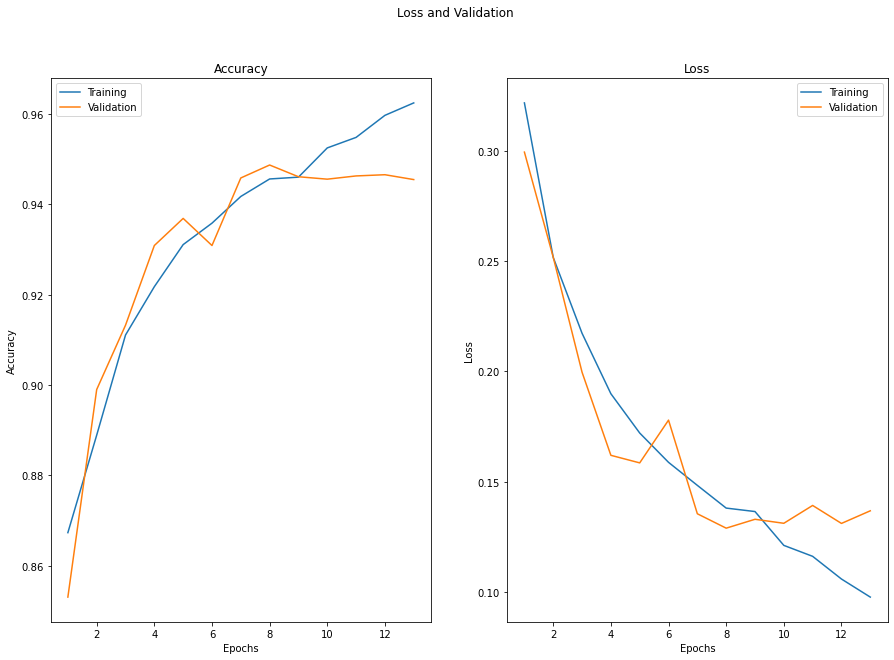

In [12]:
reset_keras()
def Train_Val_Plot(acc,val_acc,loss,val_loss):
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize= (15,10))
    fig.suptitle("Loss and Validation")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['Training', 'Validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['Training', 'Validation'])
    plt.show()
    

Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'])

# Metrics

In [13]:
#encoder1=Model(model.input, model.get_layer('classifier').output)
y_pred_prb=model.predict(x_test)
y_pred=np.round(model.predict(x_test),0)
target=["Negative","Positive"] 
cm=metrics.confusion_matrix(y_test, y_pred)
print(cm)
print('Accuracy:', np.round(metrics.accuracy_score(y_test, y_pred),3))
print('F1 Score:', np.round(metrics.f1_score(y_test, y_pred),3))
#print('AUC:', metrics.roc_auc_score(y_test, y_pred_prb),3)
print('Specificity', np.round(cm[0,0]/(cm[0,0]+cm[0,1]),3))
print(metrics.classification_report(y_test, y_pred,target_names=target))

[[13065   295]
 [  469  1535]]
Accuracy: 0.95
F1 Score: 0.801
Specificity 0.978
              precision    recall  f1-score   support

    Negative       0.97      0.98      0.97     13360
    Positive       0.84      0.77      0.80      2004

    accuracy                           0.95     15364
   macro avg       0.90      0.87      0.89     15364
weighted avg       0.95      0.95      0.95     15364



# Number of Images to Paint

In [36]:
partial=x_test[0:100,:,:,:]

# Function to Paint Anomalies based on Single Layer

In [41]:
import scipy as sp
gc.collect()
reset_keras()

partial=x_test[0:100,:,:,:]
intermediate = Model(model.input,model.get_layer("block5_conv3").output) #get the last layer output and use as model
conv_output = np.squeeze(intermediate.predict(partial))   #get the testing output
weights = model.layers[-1].get_weights()[0]  #get the weights
weights=weights[:,0]

def myplot(img):    
    conv_output2 = conv_output[img] #get the prediction
    h = int(size/conv_output2.shape[0]) #multiplying ratios for mapping
    w = int(size/conv_output2.shape[1]) #multiplying ratios for mapping
    act_maps = sp.ndimage.zoom(conv_output2, (h, w, 1), order=1)
    act_maps=act_maps.reshape((96*96,intermediate.output.shape[3]))
    out = act_maps@weights
    out=out.reshape(96,96)
    return(out)


# Paint Anamolies based on Single Layer

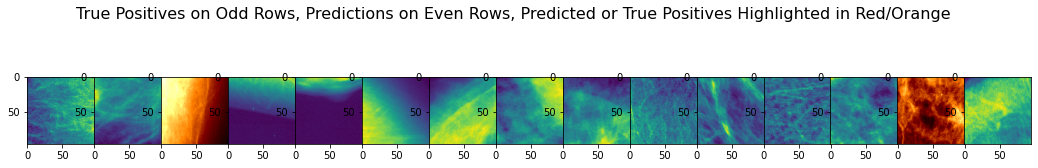

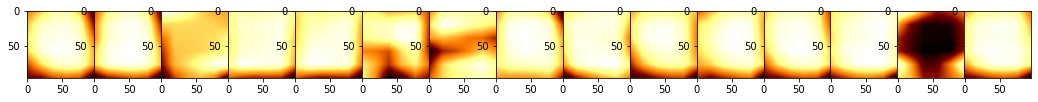

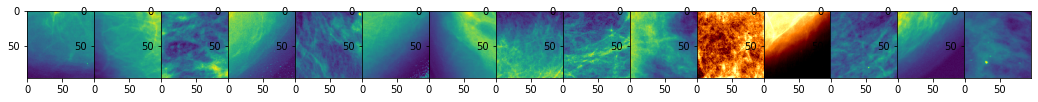

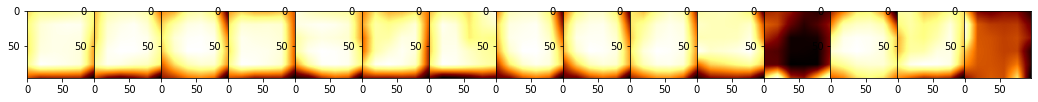

In [42]:
numim=15
   
fig, ax = plt.subplots(1,numim, figsize=[18, 3])
fig2, ax2 = plt.subplots(1,numim, figsize=[18, 3])
fig3, ax3 = plt.subplots(1,numim, figsize=[18, 3])
fig4, ax4 = plt.subplots(1,numim, figsize=[18, 3])
fig.suptitle('True Positives on Odd Rows, Predictions on Even Rows, Predicted or True Positives Highlighted in Red/Orange', fontsize=16)

zeros=np.zeros((96,96))

for i in range(numim):
    val=y_test[i]
    ax[i].imshow(x_test[i, :,:,0],) if val.astype(int)==0 else ax[i].imshow(x_train[i, :,:,0],'afmhot') 
    fig.subplots_adjust(wspace=0, hspace=0)
for i in range(numim):
    val=y_test[i]
    temp=myplot(i)
    ax2[i].imshow(temp, cmap='afmhot') #if y_pred[i]==1 else ax2[i].imshow(zeros)
    fig2.subplots_adjust(wspace=0, hspace=0)
for i in range(numim):
    val=y_test[i+numim]
    ax3[i].imshow(x_test[i+numim, :,:,0],) if val.astype(int)==0 else ax3[i].imshow(x_train[i+numim, :,:,0],'afmhot') 
    fig3.subplots_adjust(wspace=0, hspace=0)
for i in range(numim):
    val=y_test[i]
    temp=myplot(i+numim)
    ax4[i].imshow(temp, cmap='afmhot') 
    fig4.subplots_adjust(wspace=0, hspace=0)   
         

# Paint Convolutional Layer Images

In [43]:
layer_names = [layer.name for layer in model.layers] #get the names
u=18 #number of layers I will select
layer_names = [layer.name for layer in model.layers[1:u]] #get the names
layer_outputs = [layer.output for layer in model.layers[1:u]] #get the outputs
print(layer_names)

['block1_conv1', 'block1_conv2', 'block1_pool', 'block2_conv1', 'block2_conv2', 'block2_pool', 'block3_conv1', 'block3_conv2', 'block3_conv3', 'block3_pool', 'block4_conv1', 'block4_conv2', 'block4_conv3', 'block4_pool', 'block5_conv1', 'block5_conv2', 'block5_conv3']


# Get Important Layer Outputs

In [44]:
feature_map_model = Model(model.input, layer_outputs) #build the models
feature_maps = feature_map_model.predict(partial) #predict the features

# Get the Images into an Array

In [55]:
myscaler=MMS()
image_belt=[]
for layer_name, feature_map in zip(layer_names, feature_maps):  
    for i in range(numim):
        feature_image = feature_map[i, :, :, 0]
        h = int(size/feature_image.shape[0]) #multiplying ratios for mapping
        feature_image = sp.ndimage.zoom(feature_image, (h, h), order=1)
        feature_image=myscaler.fit_transform(feature_image)
        image_belt.append(feature_image)
image_belt=np.asarray(image_belt)
print(image_belt.shape)


(255, 96, 96)


# Paint the Layer Representation of the Image

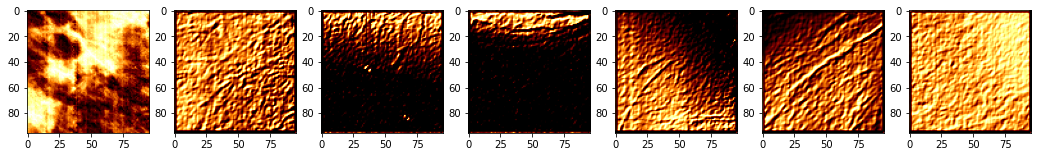

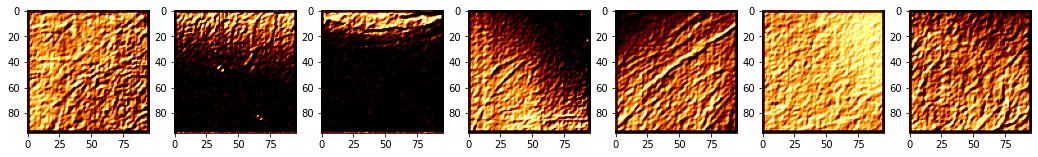

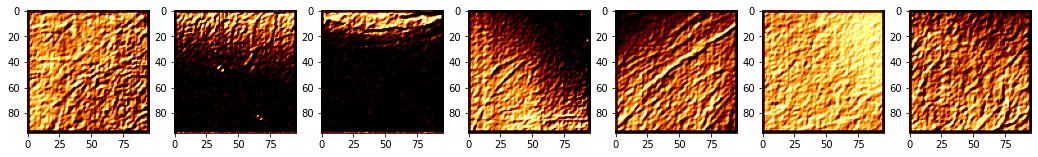

In [57]:
im=7 #number of images per line
imnum=2 #17 layers, 0 to 16....image 0 starts at 0 ends at 16; image 1 starts at 17, image 2 starts at 30
begin=imnum*17-17

fig, ax = plt.subplots(1,im, figsize=[18, 3])
fig2, ax2 = plt.subplots(1,im, figsize=[18, 3])
fig3, ax3 = plt.subplots(1,im, figsize=[18, 3])

ax[0].imshow(myscaler.fit_transform(x_test[imnum, :,:,0]),cmap='afmhot') if y_test[imnum]==1 else ax[0].imshow(x_train[imnum, :,:,0],'Greys') 
for i in np.arange(1,im):
    ax[i].imshow(image_belt[begin-1+i], cmap='afmhot')   #map for 6 other layers
for i in np.arange(0,im):
    ax2[i].imshow(image_belt[begin+i], cmap='afmhot')  #map for 
for i in np.arange(0,im):
    ax3[i].imshow(image_belt[begin+i], cmap='afmhot')


## Get the Gradient of the Score with respect to the Image Layer

In [58]:
def watch_layer(layer, tape):
    def decorator(func):
        def wrapper(*args, **kwargs):
            # Store the result of `layer.call` internally.
            layer.result = func(*args, **kwargs)
            # From this point onwards, watch this tensor.
            tape.watch(layer.result)
            # Return the result to continue with the forward pass.
            return layer.result
        return wrapper
    layer.call = decorator(layer.call)
    return layer

bx = tf.reshape(x_test[0, :, :, :], (1, 96,96, 3))
last_conv_layer = intermediate.get_layer('block5_conv3')
with tf.GradientTape() as tape:
    watch_layer(last_conv_layer, tape)  
    preds = intermediate(partial)
# Get the gradient w.r.t. the output of `last_conv_layer`
grads = tape.gradient(preds, last_conv_layer.result)  


## See Which Neurons are Activated

In [67]:
hidden_layers = K.function(
    [intermediate.layers[0].input],  # we will feed the function with the input of the first layer  
    [intermediate.layers[17].output,] # we want to get the output of the first layer
)

myneurons=hidden_layers([partial])
myneurons=np.squeeze(np.array(myneurons))
mygrads=np.array(grads)
print(np.array(myneurons).shape, mygrads.shape)

AttributeError: 'NoneType' object has no attribute '_tape'

## Get 10 Highest Active Neurons Based on Gradient wrt Loss

In [ ]:
plotnum=2
rank=myneurons*mygrads

# Resize Gradient x 10 Neurons

In [ ]:
d = np.argpartition(rank, -10)[-10:]
h = int(size/6) #multiplying ratios for mapping
w = int(size/6) #multiplying ratios for mapping
act_maps1 = sp.ndimage.zoom(d[plotnum], (h, w, 1), order=1)
act_maps1=act_maps1.reshape((96*96,512))
final=act_maps1@weights
final=final.reshape(96,96)

# Plot and Identify Activation Area

In [ ]:
fig, ax = plt.subplots(1,2, figsize=[18, 3])

test=final
x=np.argmax(np.max(test, axis=0))
y=np.argmax(np.max(test, axis=1))
ax[0].imshow(test[abs(test)>np.quantile(abs(test),.9)], 'hot') 
ax[1].imshow(x_test[plotnum, :,:,0]) if y_test[plotnum].astype(int)==0 else ax[1].imshow(x_train[plotnum, :,:,0],'hot') 
circ=Circle((x,y),10, fill=False)
ax[1].add_patch(circ)

# Saliency Map Function

In [ ]:
def saliency_map(org_img,output_layer,iters=1):
    img = org_img.astype(np.float32)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        cls_  = sess.run([output_layer], feed_dict={vgg.imgs:org_img.astype(np.float64).reshape([–1,224,224,3])}) # identify the class
        cls_ = np.array(cls_).squeeze()
        gradient = tf.gradients(cls_layer[:,cls_.argmax()],vgg.imgs) # declare the gradient function Yc w.r.t input_image
        grad_mtx = np.zeros((224,224,3))
        for i in tqdm(range(iters)): # single backprop as iters = 1, by default
            grad = sess.run([gradient], feed_dict={vgg.imgs:img.reshape([–1,224,224,3])})
            grad = np.array(grad).squeeze()
            grad_mtx+=grad
    print("\nThe image class is : '"+class_names[cls_.argmax()]+"'")
    return grad_mtx 